### 1 - Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2 - Defining Skill Catalog

In [10]:
SKILL_CATALOG = {
    # --- 1. Direct Damage Skills ---
    'Quick Strike':     {'damage': 10, 'cd': 1, 'tags': ['Damage', 'Physical']},
    'Heavy Blow':       {'damage': 25, 'cd': 3, 'tags': ['Damage', 'Physical']},
    'Wind Slash':       {'damage': 12, 'cd': 2, 'tags': ['Damage', 'Physical', 'Knockback']},
    'Shadow Strike':    {'damage': 25, 'cd': 3, 'tags': ['Damage', 'Physical', 'Stealth']},
    'Celestial Strike': {'damage': 25, 'cd': 4, 'tags': ['Damage', 'Buff_Self_Damage']},

    # --- 2. Area of Effect / Alto Impacto ---
    'Meteor Strike':    {'damage': 30, 'cd': 6, 'tags': ['Damage', 'AOE']},
    'Earthquake':       {'damage': 15, 'cd': 5, 'tags': ['Damage', 'AOE', 'Stun']},
    'Arcane Explosion': {'damage': 18, 'cd': 3, 'tags': ['Damage', 'AOE']},
    'Arcane Barrage':   {'damage': 12, 'cd': 2, 'tags': ['Damage', 'AOE']},

    # --- 3. Controle / Debuff ---
    'Stunning Hammer':  {'damage': 12, 'cd': 4, 'tags': ['Damage', 'Stun']},
    'Shield Bash':      {'damage': 8,  'cd': 2, 'tags': ['Damage', 'Stun']},
    'Thunder Clap':     {'damage': 15, 'cd': 2, 'tags': ['Damage', 'Stun']},
    'Frostbite':        {'damage': 10, 'cd': 2, 'tags': ['Damage', 'Slow']},
    'Ice Spike':        {'damage': 18, 'cd': 3, 'tags': ['Damage', 'Slow']},
    'Frost Nova':       {'damage': 0,  'cd': 5, 'tags': ['Control', 'AOE', 'Slow']},
    'Blinding Light':   {'damage': 0,  'cd': 2, 'tags': ['Debuff', 'Blind']},
    'Blade of Chaos':   {'damage': 20, 'cd': 2, 'tags': ['Damage', 'Debuff', 'Vulnerable']},
    'War Cry':          {'damage': 6,  'cd': 2, 'tags': ['Debuff_Damage']},

    # --- 4. DoT / Híbrido ---
    'Poison Shot':      {'damage': 5,  'cd': 2, 'tags': ['DoT']},
    'Poison Cloud':     {'damage': 10, 'cd': 3, 'tags': ['DoT', 'AOE']},
    'Flame Burst':      {'damage': 20, 'cd': 3, 'tags': ['Damage', 'DoT']},
    'Fireball':         {'damage': 15, 'cd': 2, 'tags': ['Damage', 'DoT']},
    'Soul Drain':       {'damage': 5,  'cd': 3, 'tags': ['DoT', 'Life_Drain']},
    'Vampiric Touch':   {'damage': 8,  'cd': 4, 'tags': ['DoT', 'Life_Drain']},

    # --- 5. Suporte / Buff / Cura ---
    'Healing Wave':     {'damage': -10, 'cd': 3, 'tags': ['Heal_Self']},
    'Divine Light':     {'damage': -15, 'cd': 4, 'tags': ['Heal_Self', 'Buff_Defense']},
    "Natures' Grasp":   {'damage': -8,  'cd': 3, 'tags': ['Heal_Self', 'Buff_Defense']},
    'Stone Shield':     {'damage': 0,   'cd': 3, 'tags': ['Buff_Defense']},
    'Berserker Rage':   {'damage': 0,   'cd': 5, 'tags': ['Buff_Self_Damage']},
    'Shadow Step':      {'damage': 0,   'cd': 1, 'tags': ['Buff_Evasion']},
}


EFFECT_RULESET = {
    # --- DEBUFFS ---
    'Slow': {
        'type': 'Debuff', 'target': 'Target', 'duration': 2,
        'stat_modifier': {'speed': -0.3}
    },
    'Vulnerable': {
        'type': 'Debuff', 'target': 'Target', 'duration': 2,
        'stat_modifier': {'defense_taken': +0.25}
    },
    'Blind': {
        'type': 'Debuff', 'target': 'Target', 'duration': 1,
        'stat_modifier': {'accuracy': -0.5}
    },
    'Debuff_Damage': {
        'type': 'Debuff', 'target': 'Target', 'duration': 3,
        'stat_modifier': {'damage_output': -0.2}
    },

    # --- CONTROLE ---
    'Stun': {
        'type': 'Control', 'target': 'Target', 'duration': 1
    },
    'Knockback': {
        'type': 'Control', 'target': 'Target', 'duration': 0
    },

    # --- DoT ---
    'Damage_Over_Time': {
        'type': 'DoT', 'target': 'Target', 'duration': 3,
        'damage_per_turn': 4
    },
    'Burn': {
        'type': 'DoT', 'target': 'Target', 'duration': 2,
        'damage_per_turn': 6
    },

    # --- BUFFS ---
    'Buff_Defense': {
        'type': 'Buff', 'target': 'Self', 'duration': 3,
        'stat_modifier': {'defense': +0.3}
    },
    'Buff_Self_Damage': {
        'type': 'Buff', 'target': 'Self', 'duration': 3,
        'stat_modifier': {'damage_output': +0.5}
    },
    'Buff_Evasion': {
        'type': 'Buff', 'target': 'Self', 'duration': 1,
        'stat_modifier': {'evasion_chance': +0.75}
    },
    'Stealth': {
        'type': 'Buff', 'target': 'Self', 'duration': 1
    },

    # --- CURA / SUSTENTO ---
    'Heal_Self': {
        'type': 'Support', 'target': 'Self', 'duration': 0
    },
    'Life_Drain': {
        'type': 'Special', 'target': 'Self', 'duration': 0,
        'potency': 0.5  # Cura 50% do dano causado
    }
}

### 3 - Power Budget System Setup

In [11]:
# Ambient base value for skills
BASE_SKILL_POINTS = 10.0

# "Discounts" based on cooldown time. Longer cooldowns allow for stronger impact.
# (Skill impact value) * (CD multiplier)
CD_MULTIPLIERS = {
    1: 1.0,   # Full cost
    2: 0.6,   # 40% discount
    3: 0.4,   # 60% discount
    4: 0.3,   # 70% discount
}

EFFECT_COSTS = {
    # Tier 2: Tactical Effects
    'Damage_Over_Time': 4.0,
    'Burn': 4.0,
    'Poison': 4.0,
    'Slow': 5.0,
    'Blind': 6.0,
    'Knockback': 4.0,
    'Stealth': 6.0,
    'Evasion': 5.0,
    'Mana_Drain': 6.0,
    'Vulnerable': 8.0,
    'Damage_Debuff': 7.0,
    'Defense_Buff': 5.0,

    # Tier 3: Strategic Effects
    'Stun': 15.0,
    'Stun_1_Turn': 15.0,
    'Area_Effect': 7.0,
    'Area_Control': 8.0,
    'Buff': 6.0,
    'Debuff': 6.0,
    'Damage_Increase': 6.0,
    'Magic_Resistance': 5.0,

    # Healing-related
    'Heal': 7.0,
    'Life_Drain': 6.0,  # Absorve dano e converte em cura

    # Defensive
    'Defense': 5.0,
}

### 4 - Defining Skill Catalog

In [12]:
def calculate_skill_power(skill_info):
    """Calculates the total Skill Points (SP) cost of a skill."""
    
    damage_cost = skill_info['damage']  # Base cost: 1 SP per damage point
    
    effect_cost = 0
    for tag in skill_info['tags']:
        effect_cost += EFFECT_COSTS.get(tag, 0)

    # Total impact is the sum of damage and effects
    total_impact = damage_cost + effect_cost
    
    # Apply cooldown "discount"
    cd_multiplier = CD_MULTIPLIERS.get(skill_info['cd'], 0.1)  # Default low value for high CDs
    
    final_power = total_impact * cd_multiplier
    
    return final_power

### 5 - Skill Power Analysis

In [13]:
def analyze_static_power(catalog):
    """Creates a DataFrame analyzing the power of each skill in the catalog."""
    
    analysis_data = []
    for name, info in catalog.items():
        power = calculate_skill_power(info)
        info['name'] = name
        info['calculated_power'] = power
        # Calculates how much the skill deviates from the base value
        info['deviation_%'] = ((power / BASE_SKILL_POINTS) - 1) * 100
        analysis_data.append(info)
        
    df_analysis = pd.DataFrame(analysis_data)
    df_analysis = df_analysis[['name', 'damage', 'cd', 'tags', 'calculated_power', 'deviation_%']]
    
    return df_analysis.sort_values(by='calculated_power', ascending=False)


# Running static analysis
df_skill_power = analyze_static_power(SKILL_CATALOG)

print("Static Power Analysis of Skills")
from IPython.display import display
display(df_skill_power)

Static Power Analysis of Skills


,name,damage,cd,tags,calculated_power,deviation_%
16,Blade of Chaos,20,2,"[Damage, Debuff, Vulnerable]",20.4,104.0
11,Thunder Clap,15,2,"[Damage, Stun]",18.0,80.0
10,Shield Bash,8,2,"[Damage, Stun]",13.8,38.0
3,Shadow Strike,25,3,"[Damage, Physical, Stealth]",12.4,24.0
1,Heavy Blow,25,3,"[Damage, Physical]",10.0,0.0
0,Quick Strike,10,1,"[Damage, Physical]",10.0,0.0
2,Wind Slash,12,2,"[Damage, Physical, Knockback]",9.6,-4.0
13,Ice Spike,18,3,"[Damage, Slow]",9.2,-8.0
21,Fireball,15,2,"[Damage, DoT]",9.0,-10.0
12,Frostbite,10,2,"[Damage, Slow]",9.0,-10.0


### 6 - Combat Simulation Function

In [16]:
def simulate_combat(entity_hp, agent_skill_names, enemy_skill_names):
    """
    Simula um combate realista aplicando todos os efeitos definidos no EFFECT_RULESET.
    """
    # Prepara os dicionários das skills para cada combatente, buscando no catálogo global
    agent_skills = {name: SKILL_CATALOG[name] for name in agent_skill_names}
    enemy_skills = {name: SKILL_CATALOG[name] for name in enemy_skill_names}
    
    # Inicializa o estado de cada combatente
    agent = {'hp': entity_hp, 'skills': agent_skills, 'cooldowns': {s: 0 for s in agent_skills}, 'effects': {}}
    enemy = {'hp': entity_hp, 'skills': enemy_skills, 'cooldowns': {s: 0 for s in enemy_skills}, 'effects': {}}
    
    turn = 0
    combatants = [agent, enemy]
    
    # Limite de segurança para evitar loops infinitos em cenários de não-dano
    max_turns = 200 

    while agent['hp'] > 0 and enemy['hp'] > 0 and turn < max_turns:
        turn += 1
        
        attacker = combatants[(turn - 1) % 2]
        defender = combatants[turn % 2]

        # --- FASE DE INÍCIO DE TURNO: Processar Efeitos ---
        active_effects = list(attacker['effects'].keys())
        is_stunned = False
        
        for effect_name in active_effects:
            if effect_name not in attacker['effects']: continue
            
            rule = EFFECT_RULESET.get(effect_name, {})
            
            if rule.get('type') == 'DoT':
                attacker['hp'] -= rule.get('damage_per_turn', 0)
            if rule.get('type') == 'Control' and effect_name == 'Stun':
                is_stunned = True
            
            attacker['effects'][effect_name]['duration'] -= 1
            if attacker['effects'][effect_name]['duration'] <= 0:
                del attacker['effects'][effect_name]

        if attacker['hp'] <= 0: break
        if is_stunned: continue

        # --- FASE DE AÇÃO ---
        available_skills = [s for s, cd in attacker['cooldowns'].items() if cd == 0]
        if not available_skills: continue # Passa o turno se não houver skills disponíveis

        skill_name = np.random.choice(available_skills)
        skill_info = attacker['skills'][skill_name]
        
        # Calcula o dano
        base_damage = skill_info.get('damage', 0)
        damage_modifier = 1.0 + attacker['effects'].get('Buff_Self_Damage', {}).get('stat_modifier', {}).get('damage_output', 0.0)
        defense_modifier = 1.0 + defender['effects'].get('Vulnerable', {}).get('stat_modifier', {}).get('defense_taken', 0.0)
        final_damage = base_damage * damage_modifier * defense_modifier

        # Aplica dano ou cura
        if base_damage < 0: # É uma cura
             attacker['hp'] -= base_damage # Subtrai um número negativo para curar
        else: # É dano
            defender['hp'] -= final_damage
        
        # Aplica efeitos especiais como Life_Drain
        if 'Life_Drain' in skill_info['tags']:
            rule = EFFECT_RULESET['Life_Drain']
            heal_amount = final_damage * rule.get('potency', 0)
            attacker['hp'] += heal_amount

        # Aplica novos efeitos de status
        for tag in skill_info['tags']:
            if tag in EFFECT_RULESET:
                rule = EFFECT_RULESET[tag]
                target = attacker if rule.get('target') == 'Self' else defender
                target['effects'][tag] = {'duration': rule['duration']}
        
        attacker['cooldowns'][skill_name] = skill_info['cd']

        # Reduz cooldowns no final do turno
        for skill in attacker['cooldowns']:
            if attacker['cooldowns'][skill] > 0:
                attacker['cooldowns'][skill] -= 1

    return turn


### 7 - Simulation Result

Average Turns to Win (Before): 12.74 (Standard Deviation: 1.58)
Average Turns to Win (After): 13.12 (Standard Deviation: 1.64)


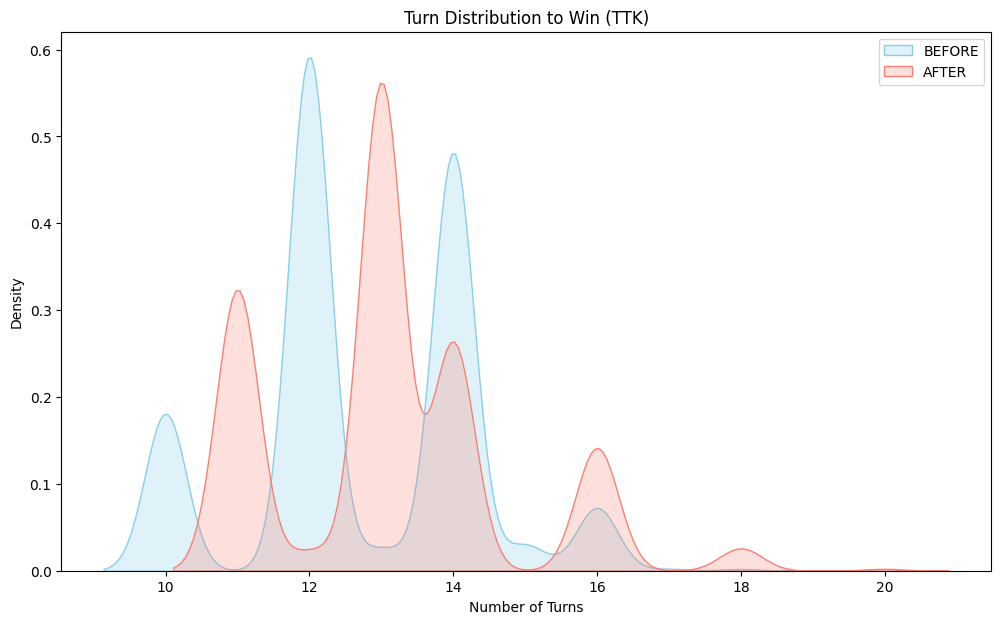

In [18]:
# Running the realistic simulations
n_simulations = 5000

# HP for combat simulation
BASE_ENTITY_HP = 100

# Loading skills for combat simulation
DEFAULT_ENEMY_SKILLS = ['Quick Strike', 'Heavy Blow', 'Blade of Chaos']
AGENT_SKILLS_BEFORE  = ['Quick Strike', 'Heavy Blow', 'Stone Shield']
AGENT_SKILLS_AFTER =   ['Divine Light', 'Heavy Blow', 'Blade of Chaos']

# Simulating combat before and after skill changes
ttk_before = [simulate_combat(BASE_ENTITY_HP, AGENT_SKILLS_BEFORE, DEFAULT_ENEMY_SKILLS) for _ in range(n_simulations)]
ttk_after = [simulate_combat(BASE_ENTITY_HP, AGENT_SKILLS_AFTER, DEFAULT_ENEMY_SKILLS) for _ in range(n_simulations)]

# Statistical summary
print(f"Average Turns to Win (Before): {np.mean(ttk_before):.2f} (Standard Deviation: {np.std(ttk_before):.2f})")
print(f"Average Turns to Win (After): {np.mean(ttk_after):.2f} (Standard Deviation: {np.std(ttk_after):.2f})")

# Distribution visualization
plt.figure(figsize=(12, 7))
sns.kdeplot(ttk_before, label='BEFORE', color='skyblue', fill=True, warn_singular=False)
sns.kdeplot(ttk_after, label='AFTER', color='salmon', fill=True, warn_singular=False)
plt.title('Turn Distribution to Win (TTK)')
plt.xlabel('Number of Turns')
plt.ylabel('Density')
plt.legend()
plt.show()
